# Eletromagnetismo e Ondulatória - Projeto Final
___
##  Simulações numéricas essenciais para transmissão de energia sem fio (WPT)

### Integrantes 
 - João Vitor Pazotti
 - Pedro Mahfuz
 - Thomas Cavalcanti Chabro

## Objetivos 
Essa etapa do projeto visa simular computacionalmente o circuito elétrico a ser utilizado no projeto para encontrar os valores ótimos de montagem. Para tanto, dividiu-se essa parte do projeto em 5 outras:

## Índice

- [Parte 1 - Elaboração do diagrama do modelo eletrodinâmico do circuito WPT](#1)
- [Parte 2 - Código do Módulo Numérico](#2)
- [Parte 3 - Construção de gráficos de I1 e I2 em função da frequência](#3)
- [Parte 4 - Construção de gráficos das potências e da eficiência em função da frequência](#4)
- [Parte 5 - Construção de um gráfico que relacione o valor de pico da tensão no secundário (no resistor 𝑅𝐶) com o coeficiente de acoplamento $k$](#5)
- [Conclusão e Validação do Modelo](#conclusao)
- [Aumentando a tensão de alimentação do primário](#fim)
___

<div id="1"></div>

## Parte 1 - Elaboração do diagrama do modelo eletrodinâmico do circuito WPT (id=1)
O circuito a ser utilizado foi cedido pelos professores e seu diagrama eletrodinâmico está exposto na Imagem 1, abaixo.
<img src="circuito_vazio.png" style="padding: 20px">
<center>Imagem 1: Circuito do Projeto, montado no Ciruit Lab</center><br>
Observa-se que o circuito se assemelha muito ao modelo de transformador elétrico apresentado em aula, exceto por capacitores no primário e no secundário. Esses componentes são utilizados nos dois circuitos com o mesmo propósito: maximizar a corrente através de uma corrente ressonante.<br>
Para ilustrar esse conceito, pode-se utilizar um circuito RLC ordinário, como na Imagem 2:
<img src="circuito_RLC.jpg" style="padding: 20px">
<center>Imagem 2: Circuito RLC ordinário, montado no Ciruit Lab</center><br>
Equacionando esse circuito, temos a seguinte equação:

<center style="padding: 20px"><h2>
$ \frac{\hat{U}_f}{R+j \omega L +\frac{1}{j \omega C}} = \hat{I} $
</h2></center>

Para esse circuito, a corrente máxima acontece quando *$j\omega L = - \frac{1}{j \omega C}$*, já que dessa forma as impedâncias do capacitor e do indutor se cancelam<br>
Fazendo manipulações algébricas, pode-se provar que a frequência angular de ressonância é dada por:
<center style="padding: 20px"><h2>
$\omega_{res} = \frac{1}{\sqrt{LC}}$
</h2></center>

Através de manipulação algébrica, descobre-se a frequência de ressonância de um sistema RLC
<center style="padding: 20px"><h2>
$f_{res} = \frac{1}{2\pi\sqrt{LC}}$
</h2></center>

___

<div id="2"></div>

# Parte 2 - Código do Módulo Numérico

### Descrição
Essa parte foca na escrita de um código em Python que simula o modelo esquematizado anteriormente. Os valores utilizados já estão de acordo com os valores utilizados no sistema real, exceto o valor do coeficiente de acoplamento, escolhido arbritariamente em um primeiro momento (depois serão feitas simulações variando esse fator)

Imports dos módulos

In [278]:
from cmath import *
from numpy import linalg
import numpy as np
import matplotlib.pyplot as plt

Variáveis do Transformador

In [279]:
# Parâmetro medidos da bobina real
R1 = 0.945 + 2.7
R2 = 0.957 + 2.7 
# Para as Resistências, adicionamos mais 0.5 ohm por conta da resistência dos cabos utilizados
L1 = 261.9e-6
L2 =  266.5e-6

# Parâmetro k escolhido para análise inicial
k = 0.1

### Escolhendo um capacitor

Escolheu-se uma bobina com $300 \mu H$, portanto sobra escolher um capacitor e uma respectiva frequência de ressonância para análise. Os capacitores disponíveis no laboratório possuiam as seguintes valores de capacitância:


In [280]:
cap = [0.1e-6, 150e-9, 1e-6, 4.7e-6, 0.47e-6]

A partir desses valores, pode-se calcular a frequência de ressonância para cada capacitor (segundo nosso valor delimitado de bobina)

In [281]:
for C in cap:
    f = 1/(2*pi*sqrt(L1*C))
    print(f'Para o capacitor de {C}F, fres = {f.real}')

Para o capacitor de 1e-07F, fres = 31099.42664965948
Para o capacitor de 1.5e-07F, fres = 25392.575528259567
Para o capacitor de 1e-06F, fres = 9834.502213826334
Para o capacitor de 4.7e-06F, fres = 4536.317603841976
Para o capacitor de 4.7e-07F, fres = 14345.095818058033


Elegeu-se o capacitor de $0.1 \mu F$ para a montagem, utilizando uma frequência de $31.099Hz$, pois esses valores mostraram ser os mais eficientes.

In [282]:
C1 = 0.1e-6
C2 = 0.1e-6

# Carga utilizada para análise
Rc = 330

# Frequência de ressonância, segundo equações apresentadas anteriormente
w = 1/sqrt(L1*C1)
f = 1/(2*pi*sqrt(L1*C1))

# Cálculo de impedâncias
XL1 = 1j*w*L1
XL2 = 1j*w*L2
XC1 =1 /(1j*w*C1)
XC2 =1 /(1j*w*C2)
M = k*sqrt(L1*L2)
XM = 1j*w*M

Funções que modelam o comportamento do circuito

In [283]:
def CalcularTransformador(V1, Rc):
    """
    Calcula as correntes do circuito a partir dos parâmetros no primário e no secundário
    Função desenvolvida a partir de um código cedido pelos professores para cálculo de
    corrente em um transformador, mas adaptado para o novo circuito

    Parâmetros:
     - V1: Tensão de alimentação do primário
     - Rc: Resistência da Carga
    """
    Z=np.array([[R1+XL1+XC1, -XM],[-XM, XL2+R2+((Rc*XC2)/(Rc+XC2))]])
    V=np.array([V1,0])
    I=np.dot(linalg.inv(Z),V)
    return I[0], I[1]

In [284]:
def S(V:complex, I:complex):
    """
    Calcula a potência total S do componente/sistema

    Parâmetros:
     - V: Tensão que passa no componente/sistema
     - I: Corrente que passa no componente/sistema
     - Z: Impedância local
    """

    Vpico = abs(V)
    Ipico = abs(I)
    Veficaz = Vpico/sqrt(2)
    Ieficaz = I/sqrt(2)
    Ief_conj = Ieficaz.conjugate()

    S = Veficaz*Ief_conj

    return S

### Alimentação no Primário
O gerador de sinais não tem potência suficiente para alimentar o circuito primário, por isso foi necessário trabalhar com um circuito denominado "meia-ponte", esquematizado à seguir:
<img src="circuito_alimentacao.png">
Esse circuito fornece uma onda quadrada, com sinal descrito por:<br>
<center>
<h3>
$U_f(t)=\frac{2}{{\pi}}.V_p.cos({\omega}t)$
    </h3>
</center>

In [285]:
# Tensão de alimentação a partir do PWM
Uf = 2/pi*5

In [286]:
# Tensão de alimentação a partir do PWM
Rc = 330

#A função calcula as duas correntes
i1, i2 = CalcularTransformador(Uf, Rc)

#Com as correntes, é possível calcular o V2 
V2 = ((XC2*Rc)/(XC2+Rc)) * i2

#Potência 
S2=S(V2,i2)

print('VALORES CALCULADOS PARA UM COEFICIENTE DE ACOPLAMENTO DE 0.1')
print('---'*20)
print("Corrente no primario (i1)          --> {0:.5f} A".format(abs(i1)))
print("Corrente no secundário (i2)        --> {0:.5f} A".format(abs(i2)))
print("Tensão no secundário (V2)          --> {0:.5f} V".format(abs(V2)))
print("Potência eficaz (S2ef)             --> {0:.5f} W".format(S2.real))
print("Frequência de ressonância (f)      --> {0:.5f} Hz".format(f.real))

VALORES CALCULADOS PARA UM COEFICIENTE DE ACOPLAMENTO DE 0.1
------------------------------------------------------------
Corrente no primario (i1)          --> 0.53775 A
Corrente no secundário (i2)        --> 0.23934 A
Tensão no secundário (V2)          --> 12.10383 V
Potência eficaz (S2ef)             --> 0.16154 W
Frequência de ressonância (f)      --> 31099.42665 Hz


___

<div id="3"></div>

# Parte 3 - Construção de gráficos de I1 e I2 em função da frequência:

### Descrição

Para essa sub-etapa, busca-se plotar os módulos das correntes no primário e no secundário (I1 e I2) para um valor de coeficiente de acoplamento inicialmente fixo (nesse caso, utilizou-se $k = 0.1$) e, em seguida, variá-lo. Essa etapa busca responder a duas perguntas:
1) A frequência para a qual as correntes são máximas é coincidente com a frequência de ressonância que vocês obtiveram na atividade 1? <br>
2) O que acontece com os gráficos dos módulos das correntes quando se altera o 𝑘 do circuito? 

### Para um valor de k fixo

In [287]:
# Função utilizada para modelar as correntes I1 e I2 com f variante
def ListaI1I2(lista_f,k):
    """
    Retorna listas com os valores da corrente no primário e 
    no secundário a partir de uma variação na frequência

    Parâmetros:
     - lista_f: lista com valores variantes de f
     - k: coeficiente de acoplamento
    """
    I1=[]
    I2=[]
    for f in lista_f:
        M = k*sqrt(L1*L2)
        w = 2*pi*f
        XL1 = 1j * w * L1
        XL2 = 1j * w * L2
        XM = 1j * w * M
        XC1 = 1/(1j*w*C1)
        XC2 = 1/(1j*w*C2)

        Z=np.array([[R1+XL1+XC1, -XM],[-XM, XL2+R2+(Rc*XC2)/(Rc+XC2)]])
        V=np.array([Uf,0])
        I=np.dot(linalg.inv(Z),V)
       
        I1.append(abs(I[0]))
        I2.append(abs(I[1]))

    return I1,I2

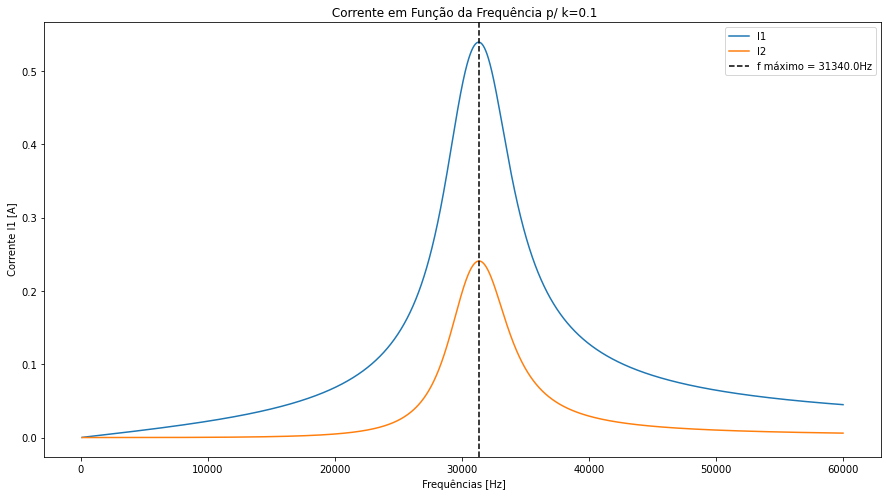

In [288]:
lista_f = np.arange(100,60e3,10)
k = 0.1

plt.figure(figsize=(15,8))
I1, I2 = ListaI1I2(lista_f,k)
f_maximo = lista_f[I2.index(max(I2))]
plt.plot(lista_f,I1,label="I1")
plt.plot(lista_f,I2,label="I2")
plt.axvline(x=f_maximo, color='black', linestyle='--', label=f'f máximo = {f_maximo.real}Hz')
plt.title(" Corrente em Função da Frequência p/ k=0.1")
plt.xlabel(" Frequências [Hz]")
plt.ylabel(" Corrente I1 [A]")
plt.legend()
plt.show()

In [289]:
# Achando a frequência I1 e I2
print(f'A corrente máxima atingida é {round(max(I1),2)} A para I1 e {round(max(I2), 2)} A para I2, encontrados sob uma frequência de {f_maximo}Hz')

A corrente máxima atingida é 0.54 A para I1 e 0.24 A para I2, encontrados sob uma frequência de 31340.0Hz


O gráfico acima nos permite concluir que, para um $k=0.1$, o valor de frequência que maximiza as correntes de fato coincide com o valor teórico da frequência de ressonância ($31340 Hz$ e $31099 Hz$, respectivamente), respondendo à pergunta número 1.

### Para valores de k variáveis

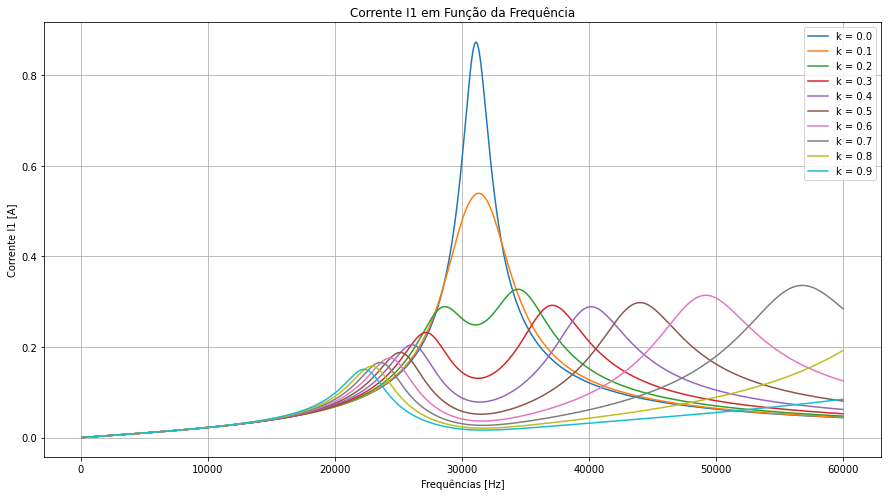

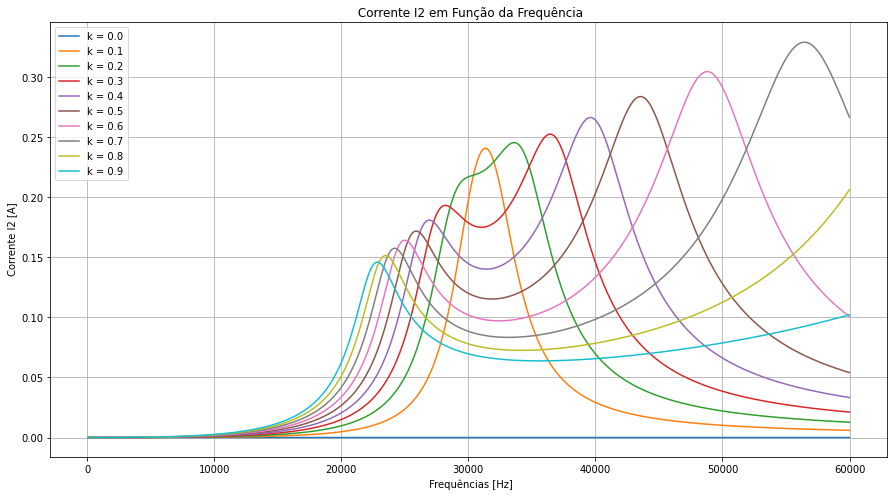

In [290]:
lista_k = np.arange(0,1,0.1)
picosI1=[]

plt.figure(figsize=(15,8))
for k in lista_k:
    I1, I2 = ListaI1I2(lista_f,k)
    maximo=max(I1)
    picosI1.append(maximo)
    plt.plot(lista_f,I1,label="k = {0:.1f}".format(k))
    plt.title("Corrente I1 em Função da Frequência")
    plt.xlabel("Frequências [Hz]")
    plt.ylabel("Corrente I1 [A]")
    plt.legend()

plt.grid()
plt.show()
picosI2=[]

plt.figure(figsize=(15,8))
for k in lista_k:
    I1, I2 = ListaI1I2(lista_f,k)
    maximo=max(I2)
    picosI2.append(maximo)
    plt.plot(lista_f,I2,label="k = {0:.1f}".format(k))
    plt.title(" Corrente I2 em Função da Frequência")
    plt.xlabel(" Frequências [Hz]")
    plt.ylabel(" Corrente I2 [A]")
    plt.legend()
    
plt.grid()
plt.show() 

Observa-se que para valores de $k$ pequenos, em torno de 0.1, o valor da corrente é máximo quando a frequência é em torno de $31kH$, coincidindo com a frequência de ressonância calculada. Contudo, conforme o coeficiente de acoplamento (k) cresce, também cresce o valor da frequência que maximiza a corrente.

### Gráfico de Picos da Corrente Î1

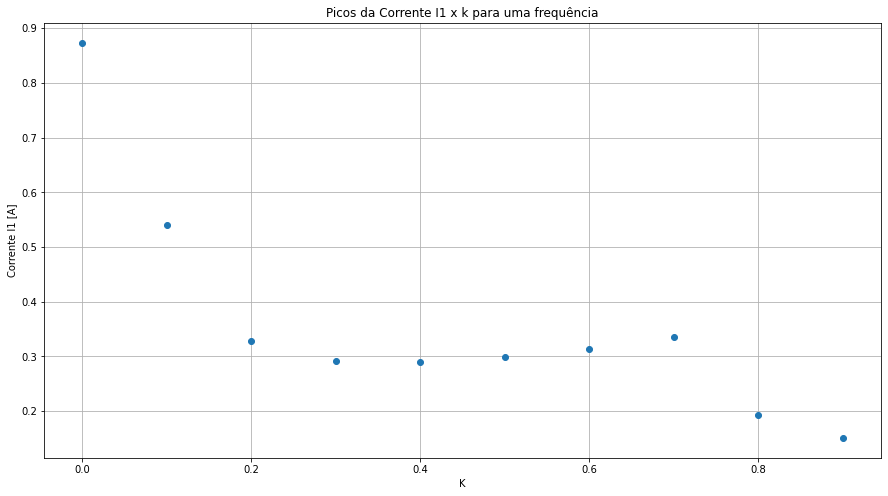

In [291]:
plt.figure(figsize=(15,8))
plt.plot(lista_k,picosI1,"o")
plt.title("Picos da Corrente I1 x k para uma frequência")
plt.xlabel("K")
plt.ylabel("Corrente I1 [A]")
plt.grid()
plt.show()

### Gráfico de Picos da Corrente Î2

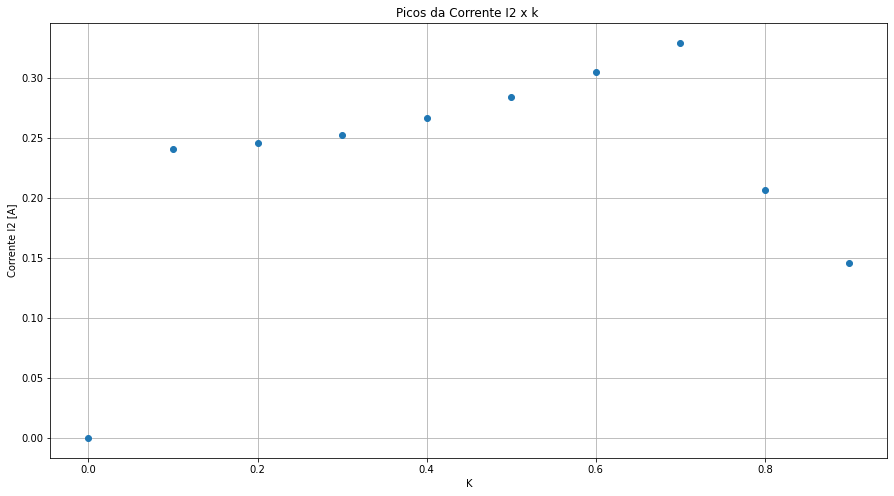

In [292]:
plt.figure(figsize=(15,8))
plt.plot(lista_k,picosI2,"o")
plt.title("Picos da Corrente I2 x k ")
plt.xlabel("K")
plt.ylabel("Corrente I2 [A]")
plt.grid()
plt.show()

___
<div id="4"></div>

## Parte 4 - Construção de gráficos das potências e da eficiência em função da frequência

### Descrição

Essa parte tem por objetivo a construção de 3 gráficos:
 - Gráfico 1: Potência real de entrada em função da frequência da fonte <br>
 - Gráfico 2: Potência real de saída em função da frequência da fonte <br>
 - Gráfico 3: Eficiência em função da frequência da fonte

### 1: Gráfico da Potencia S1 em Funcão da Frequência

In [293]:
def ListaI1I2S1S2(lista_f,lista_k):
    I1=[]
    I2=[]
    S1=[]
    S2=[]
    for f in lista_f:
        M = lista_k*sqrt(L1*L2)
        w = 2*pi*f
        XL1 = 1j * w * L1
        XL2 = 1j * w * L2
        XM = 1j * w * M
        XC1 = 1/(1j*w*C1)
        XC2 = 1/(1j*w*C2)

        Z=np.array([[R1+XL1+XC1, -XM],[-XM, XL2+R2+(Rc*XC2)/(Rc+XC2)]])
        V=np.array([Uf,0])
        I=np.dot(linalg.inv(Z),V)
        
        i1,i2=I[0],I[1]
        
        Zeq=(Rc*XC2)/(Rc+XC2)
        
        V2 = i2 * Zeq
        
        IRc = V2/Rc
        
        S1ef = (Uf * i1.conjugate())/2
        S2ef = (V2 * IRc.conjugate())/2

        I1.append(abs(i1))
        I2.append(abs(i2))
        S1.append(S1ef.real)
        S2.append(S2ef.real)
        
    return I1,I2,S1,S2

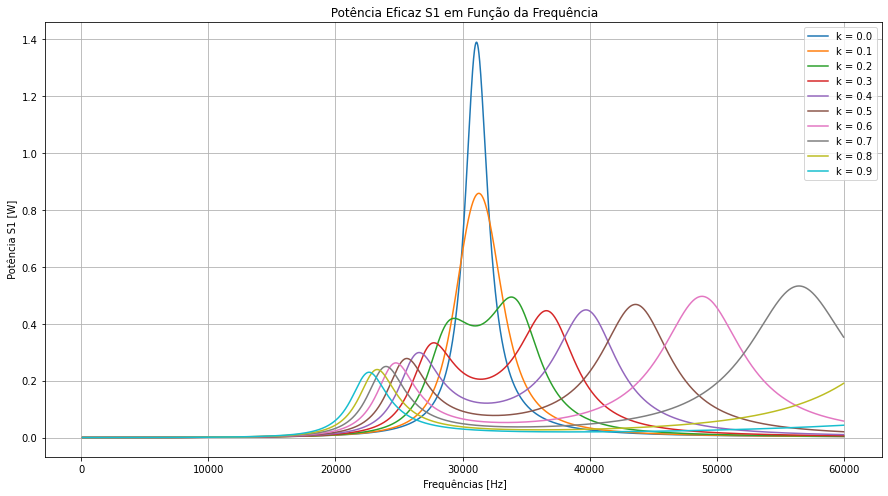

In [294]:
plt.figure(figsize=(15,8))
picosS1=[]
for k in lista_k:
    I1, I2, S1ef, S2ef = ListaI1I2S1S2(lista_f,k)
    maximo=max(S1ef)
    picosS1.append(maximo)
    plt.plot(lista_f,S1ef,label="k = {0:.1f}".format(k))
    plt.title(" Potência Eficaz S1 em Função da Frequência")
    plt.xlabel(" Frequências [Hz]")
    plt.ylabel(" Potência S1 [W]")
    plt.legend()

ax=plt.gca()
plt.grid()
plt.show() 

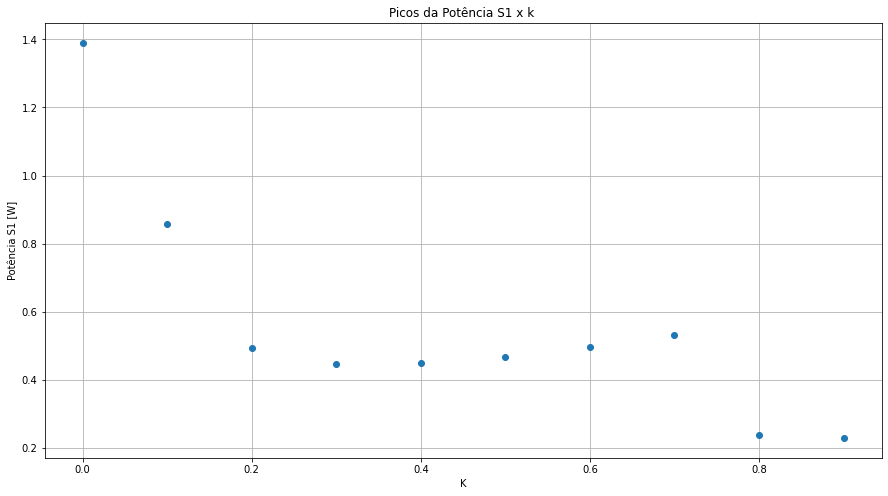

In [295]:
plt.figure(figsize=(15,8))
plt.plot(lista_k,picosS1,"o")
plt.title("Picos da Potência S1 x k ")
plt.xlabel("K")
plt.ylabel("Potência S1 [W]")
plt.grid()
plt.show()

### 2: Gráfico da Potencia S2 em Funcão da Frequência

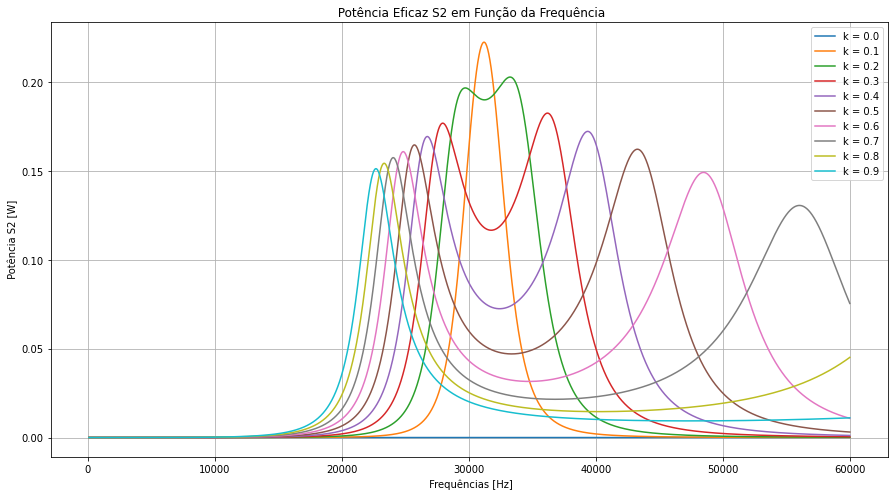

In [296]:
plt.figure(figsize=(15,8))
picosS2=[]
for k in lista_k:
    I1, I2, S1ef, S2ef = ListaI1I2S1S2(lista_f,k)
    maximo=max(S2ef)
    picosS2.append(maximo)
    plt.plot(lista_f,S2ef,label="k = {0:.1f}".format(k))
    plt.title(" Potência Eficaz S2 em Função da Frequência")
    plt.xlabel(" Frequências [Hz]")
    plt.ylabel(" Potência S2 [W]")
    plt.legend()

ax=plt.gca()
plt.grid()
plt.show() 

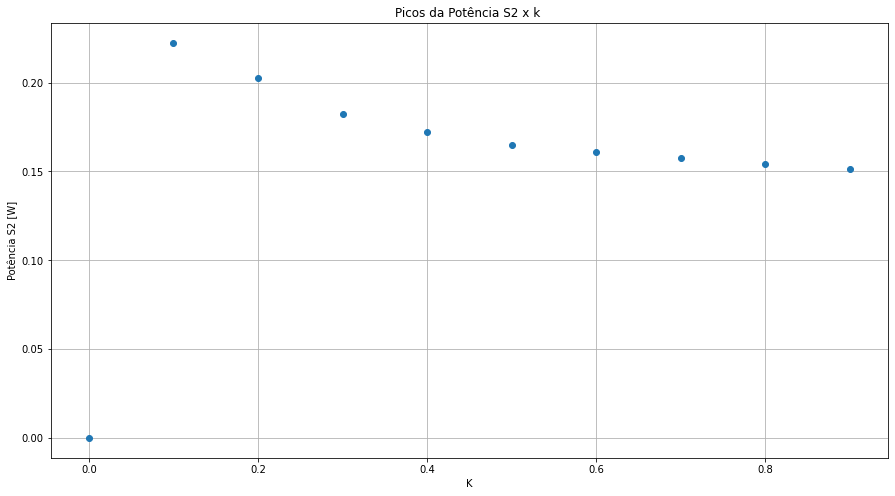

In [297]:
plt.figure(figsize=(15,8))
plt.plot(lista_k,picosS2,"o")
plt.title("Picos da Potência S2 x k ")
plt.xlabel("K")
plt.ylabel("Potência S2 [W]")
plt.grid()
plt.show()

### 3: Eficiência x Frequência

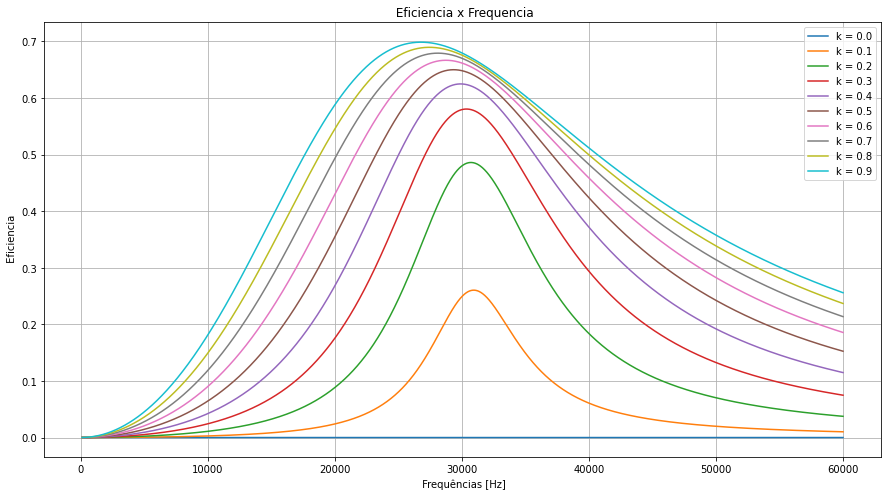

In [298]:
plt.figure(figsize=(15,8))

for k in lista_k:
    I1, I2, S1ef, S2ef = ListaI1I2S1S2(lista_f,k)
    rendimento=[]
    for i in range(len(S2ef)):
        n = S2ef[i]/S1ef[i]
        rendimento.append(n)
    plt.plot(lista_f,rendimento,label="k = {0:.1f}".format(k))
    plt.title(" Eficiencia x Frequencia")
    plt.xlabel(" Frequências [Hz]")
    plt.ylabel(" Eficiencia")
    plt.legend()

plt.grid()
plt.show() 

---

<div id="5"></div>

# Parte 5 - Construção de um gráfico que relacione o valor de pico da tensão no secundário (no resistor 𝑅𝐶) com o coeficiente de acoplamento $k$

Para essa atividade, use a frequência de ressonância natural do conjunto 𝐿𝐶, que ficará fixa para diferentes valores de 𝑘. A ideia, com a simulação, é identificar se existe um fator de acoplamento ótimo, com o qual a tensão no secundário é máxima (e, por conseguinte, a potência recebida também será máxima).

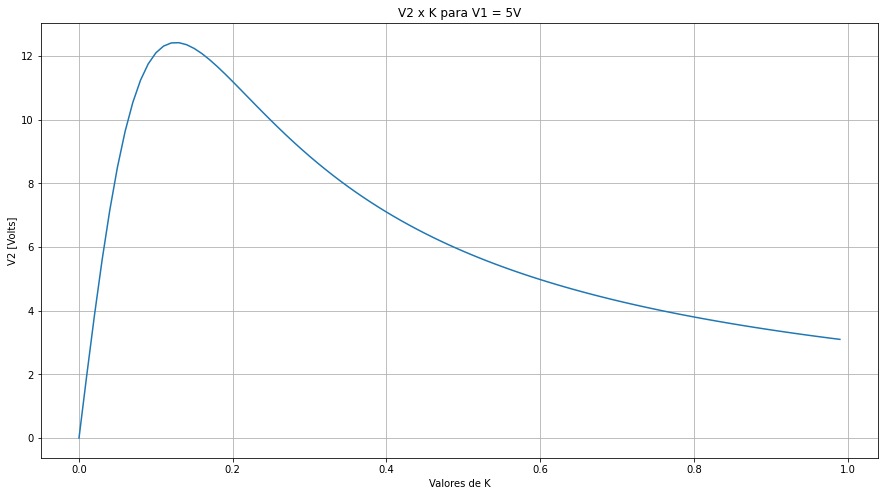

In [299]:
espacos = np.arange(0,1, 0.01)
V2 = []
plt.figure(figsize=(15,8))
for k in espacos:
    M = k*sqrt(L1*L2)
    XM = 1j * w * M
    i1, i2 = CalcularTransformador(Uf, Rc)
    zeq=(XC2*Rc)/(XC2+Rc)
    v2 = zeq * i2
    V2.append(abs(v2))
    
plt.plot(espacos,V2)
plt.title("V2 x K para V1 = 5V")
plt.xlabel("Valores de K")
plt.ylabel("V2 [Volts]")
plt.grid()
plt.show()

In [300]:
print(f'O valor máximo encontrado para V2 foi {max(V2)} sob um k = {espacos[V2.index(max(V2))]}')

O valor máximo encontrado para V2 foi 12.423847329853267 sob um k = 0.13


Vemos que existe, sim, um valor de k que maximiza a tensão na carga (e, portanto, sua potência). Quando se utiliza um $k = 0.13$, encontra-se uma tensão máxima de $12.42 V$

___

<div id="conclusao"></div>

# Conclusão e Validação do Modelo

In [301]:
dist = np.arange(0, 24, 1)
volt = [7.1, 7.5,7.9,8.4, 10, 11.4, 12.5, 11.7, 9.5, 8.8, 8,
        7.6, 7.2, 6.8, 6.4, 6, 5.6, 5.2, 4.8, 4.4, 4.1, 3.9, 3.86, 3.84]

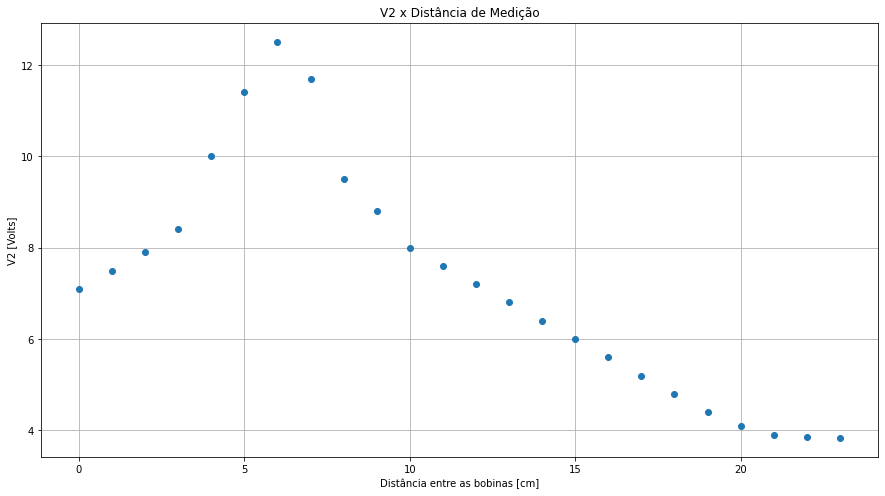

In [302]:
plt.figure(figsize=(15,8))
plt.plot(dist, volt, 'o')
plt.title("V2 x Distância de Medição")
plt.xlabel("Distância entre as bobinas [cm]")
plt.ylabel("V2 [Volts]")
plt.grid()
plt.show()

Vemos que o formato do gráfico de V2 x Distância de Medição tem um formato semelhante com o de V2 x K - há uma menor tensão menor de princípio, que aumenta logo em seguida, e que volta a descer depois. Esse comportamento está de acordo com o esperado, o que é um indício de que os resultados estão de fato de acordo com o modelo. Mas e os valores, estão parecidos?

In [303]:
print('Valor máximo de tensão segundo o modelo....:', max(V2), 'V')
print('Valor máximo de tensão medido..............:', max(volt),'V')
print('Potência máxima esperada................:', ((max(V2)/sqrt(2))**2/330).real, 'W')
print('Potência máxima transmitida................:', ((max(volt)/sqrt(2))**2/330).real, 'W')
print(f'O valor máximo de modelo é {round((max(V2)/max(volt)-1)*100)}% maior do que o medido')

Valor máximo de tensão segundo o modelo....: 12.423847329853267 V
Valor máximo de tensão medido..............: 12.5 V
Potência máxima esperada................: 0.23386664011439717 W
Potência máxima transmitida................: 0.23674242424242414 W
O valor máximo de modelo é -1% maior do que o medido


Text(0, 0.5, 'Valores de K')

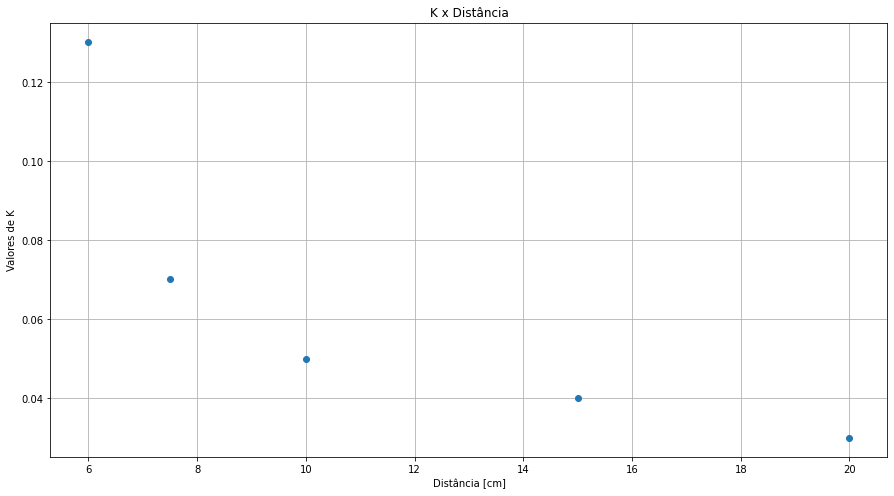

In [309]:
k=[0.13,0.07,0.05,0.04,0.03] 
d=[6,7.5,10,15,20]
plt.figure(figsize=(15,8))
plt.plot(d,k,"o")
plt.title("K x Distância")
plt.grid()
plt.xlabel("Distância [cm]")
plt.ylabel("Valores de K")

___

<div id='fim'> </div>

# Aumentando a tensão de alimentação do primário

Podemos desacoplar o circuito de alimentação do primário, aumentando a alimentação dos transistores e do cirucito como um todo sem ultrapassar o limite de 5V para o chip. Dessa forma, chegamos a transmitir 36V a partir do gerador de corrente contínua.

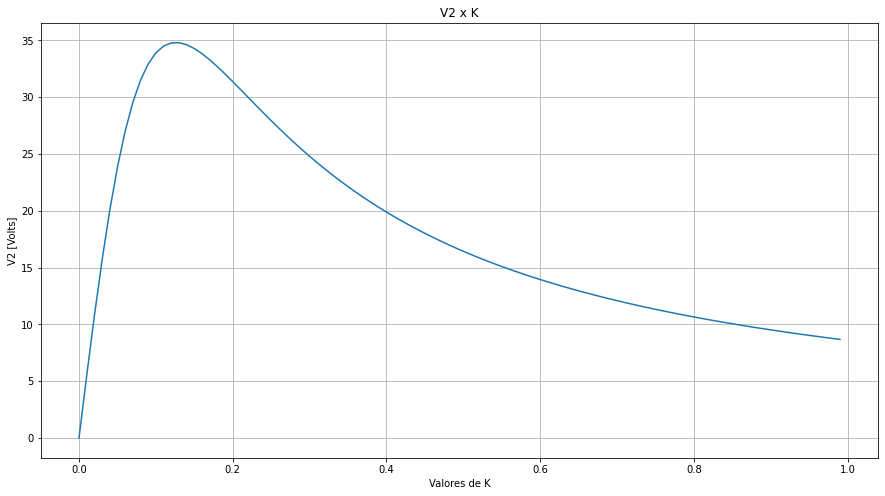

Tensão máxima esperada.....................: 34.78677252358915 V
Tensão máxima transmitida..................: 36.3 V
Potência máxima esperada................: 1.8335144584968741 W
Potência máxima transmitida................: 1.9964999999999995 W


In [312]:
Uf = 2/pi*14

espacos = np.arange(0,1, 0.01)
V2 = []
plt.figure(figsize=(15,8))
for k in espacos:
    M = k*sqrt(L1*L2)
    XM = 1j * w * M
    i1, i2 = CalcularTransformador(Uf, Rc)
    zeq=(XC2*Rc)/(XC2+Rc)
    v2 = zeq * i2
    V2.append(abs(v2))
    
plt.plot(espacos,V2)
plt.title("V2 x K")
plt.xlabel("Valores de K")
plt.ylabel("V2 [Volts]")
plt.grid()
plt.show()

print('Tensão máxima esperada.....................:', max(V2), 'V')
print('Tensão máxima transmitida..................:', 36.3, 'V')
print('Potência máxima esperada................:', ((max(V2)/sqrt(2))**2/330).real, 'W')
print('Potência máxima transmitida................:', ((36.3/sqrt(2))**2/330).real, "W")